In [1]:
%pylab inline
import seaborn as sns
from numba import njit

from random import randint
from copy import deepcopy
from matplotlib import colors

Populating the interactive namespace from numpy and matplotlib


# Task 2: Julia set

Julia Set - the set of points, the dynamics in the vicinity of which, in a certain sense, is unstable with respect to small perturbations of the initial position. Iterative formula looks like this:
$$
z_{i+1}=z_i^2+c, 
$$
where $z$ initialised as point on the complex plain.

If the modulus of the $n^{th}$ iteration is greater than $R$ (conditional infinity border), then the iterations of the function $z$ diverge.
$$
R = \frac{1 + \sqrt{1+4 |c|}} {2}
$$

The colour can be chosen in accordance with the iteration number when $R$ threshold exceeding occured. White colour - small number of iterations. Black colour - threshold exceeding did not occur. Other colours - intermediate.

### Subtask 1: Black and white colors of pixels are correct

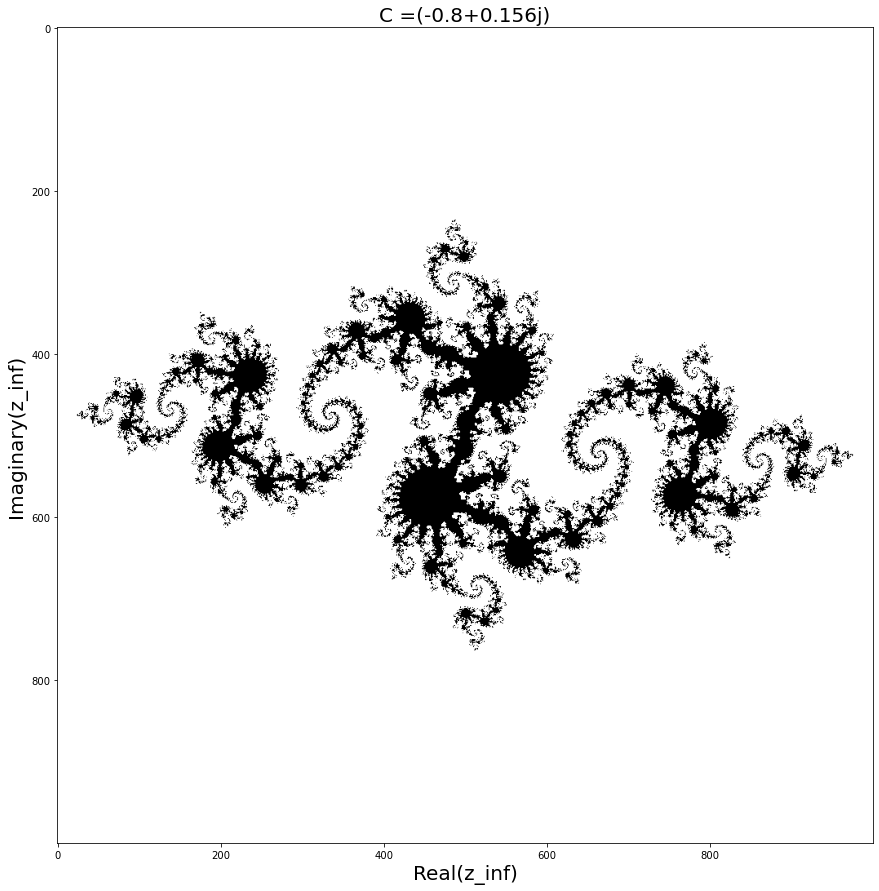

In [2]:
def juliaSetBlack(c = complex(0.28, 0.0113), size = 1.6, pixels = 100, max_iterations = 100):
    minRe, maxRe, minIm,maxIm = -size, size, -size, size # ranges of Re, Im parts
    pointsRe, pointsIm = pixels, pixels # image size
    max_iterations = max_iterations # the max number of iterations of main function z0 = z0 ** 2 + c
    # infinity_border = 200 # consider all higher values as infinity
    infinity_border = (1 + np.sqrt(1 + 4 * abs(c))) / 2
    image = np.ones((pointsRe, pointsIm)) # image with black colors

    # for each complex value (pixel on Re, Im complex plane)
    for ip, Re in enumerate(np.linspace(minRe, maxRe, pointsRe)): # this axis goes down
        for iq, Im in enumerate(np.linspace(minIm, maxIm, pointsIm)): # this axis goes right
            z0 = complex(Re, Im) # consider current z0
            # do iterations
            for k in range(max_iterations):
                z0 = z0 ** 2 + c
                
                # if z0 higher than our inf
                if abs(z0) > infinity_border:
                    # set colour of pixel as white
                    image[ip, iq] = 0
                    break
                    
    plt.figure(figsize=(15, 15))
    plt.title('С ='+ str(c), fontsize=20);
    plt.ylabel('Imaginary(z_inf)', fontsize=20)
    plt.xlabel('Real(z_inf)', fontsize=20)
    plt.imshow(np.rot90(image), cmap='Greys')
    plt.show()
    
juliaSetBlack(c = complex(-0.8, 0.156), size = 1.6, pixels = 1000, max_iterations = 100)

### Subtask 2: Different colors for bifurcation points
Without jit

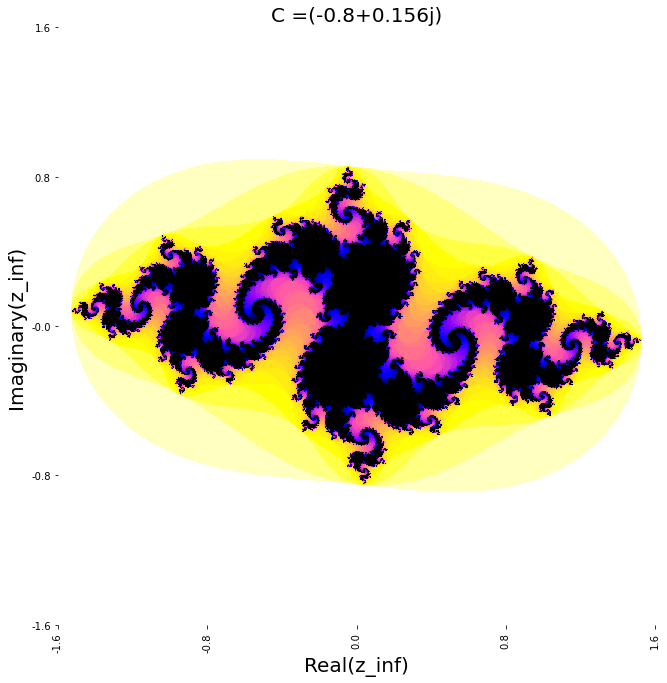

In [3]:
def juliaSetRainbow(c = complex(0.28, 0.0113), size = 1.6, pixels = 100, max_iterations = 100):
    minRe, maxRe, minIm,maxIm = -size, size, -size, size # ranges of Re, Im parts
    pointsRe, pointsIm = pixels, pixels # image size
    max_iterations = max_iterations # the max number of iterations of main function z0 = z0 ** 2 + c
    # infinity_border = 200 # consider all higher values as infinity
    infinity_border = (1 + np.sqrt(1 + 4 * abs(c))) / 2
    image = np.zeros((pointsRe, pointsIm)) # image with black colors

    # for each complex value (pixel on Re, Im complex plane)
    for ip, Re in enumerate(np.linspace(minRe, maxRe, pointsRe)): # this axis goes down
        for iq, Im in enumerate(np.linspace(minIm, maxIm, pointsIm)): # this axis goes right
            z0 = complex(Re, Im) # consider current z0
            # do iterations
            for k in range(max_iterations):
                z0 = z0 ** 2 + c
                
                # if z0 higher than our inf
                if abs(z0) > infinity_border:
                    # set colour of pixel as white
                    image[ip, iq] = max_iterations - k
                    break

    image = np.rot90(image)     
    plt.figure(figsize=(14, 11))
    sns.heatmap(image, vmin=0, vmax=max_iterations, center= max_iterations/2, cmap= 'gnuplot2', cbar=False, square=True,
                # cbar_kws= {'orientation': 'vertical'}
               )
    
    plt.title('С ='+ str(c), fontsize=20);
    plt.ylabel('Imaginary(z_inf)', fontsize=20)
    plt.xlabel('Real(z_inf)', fontsize=20)
    plt.xticks(np.linspace(0, pixels-1, 5), np.round(np.linspace(-size, size, 5),2))
    plt.yticks(np.linspace(0, pixels-1, 5), -np.round(np.linspace(-size, size, 5),2))
    
juliaSetRainbow(c = complex(-0.8, 0.156), size = 1.6, pixels = 1000, max_iterations = 50)

With jit

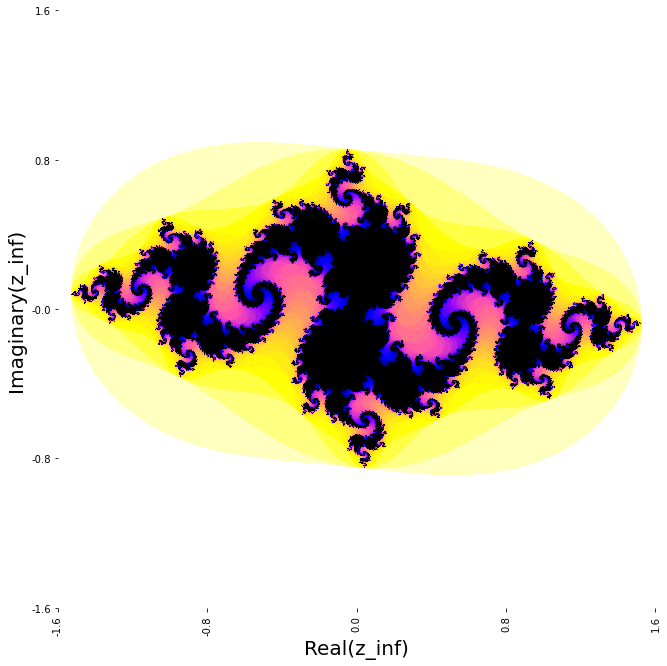

In [4]:
@njit(fastmath=True)
def count(c, size, pixels, max_iterations, infinity_border):
    
    minRe, maxRe, minIm, maxIm = -size, size, -size, size # ranges of Re, Im parts
    pointsRe, pointsIm = pixels, pixels # image size
    max_iterations = max_iterations # the max number of iterations of main function z0 = z0 ** 2 + c
    
    #infinity_border = infinity_border # consider all higher values as infinity
    
    infinity_border = (1 + np.sqrt(1 + 4 * abs(c))) / 2
    image = np.zeros((pointsRe, pointsIm)) # image with black colors
    
    # for each complex value (pixel on Re, Im complex plane)
    for ip, Re in enumerate(np.linspace(minRe, maxRe, pointsRe)): # this axis goes down
        for iq, Im in enumerate(np.linspace(minIm, maxIm, pointsIm)): # this axis goes right
            z0 = complex(Re, Im) # consider current z0
            
            # do iterations (default color - black = 0)
            # image[ip, iq] = 0 (black)
            for k in range(max_iterations):
                # calculate current z0
                z0 = z0 ** 2 + c
                
                # if z0 highet than infinity_border
                if abs(z0) >= infinity_border:
                    # set colour of pixel:
                    # less k => fast growth, higher k => slow growth
                    # => k = 0 - white, k = max_iterations - black
                    image[ip, iq] =  max_iterations - k
                    break
    
    return image

def juliaSetRainbow(c = complex(0.28, 0.0113), size = 1.6, pixels = 100, max_iterations = 100, infinity_border = 300, a_val = 0):
    
    image = count(c, size, pixels, max_iterations, infinity_border)
    image = np.rot90(image)
    
    fig = plt.figure(figsize=(14, 11))
    
    sns.heatmap(image, vmin=0, vmax=max_iterations, center= max_iterations/2, cmap= 'gnuplot2', cbar=False, square=True,
                # cbar_kws= {'orientation': 'vertical'}
               )
    
    # plt.title('С = exp(i*' + str(np.round(a_val,3)) + ')', fontsize=20)
    plt.ylabel('Imaginary(z_inf)', fontsize=20)
    plt.xlabel('Real(z_inf)', fontsize=20)
    plt.xticks(np.linspace(0, pixels-1, 5), np.round(np.linspace(-size, size, 5),2))
    plt.yticks(np.linspace(0, pixels-1, 5), -np.round(np.linspace(-size, size, 5),2))
    plt.close(fig)

    return fig, image
    
fig, image = juliaSetRainbow(c = complex(-0.8, 0.156), size = 1.6, pixels = 2000, max_iterations = 50, infinity_border = 0, a_val = 0)
fig

### Subtask 3: Generate figure of Julia set (c = 1-r) where r is the golden ratio. Label the axes (Re(z0), Im(z0)), fontsize should be 20, figsize = (14,11)

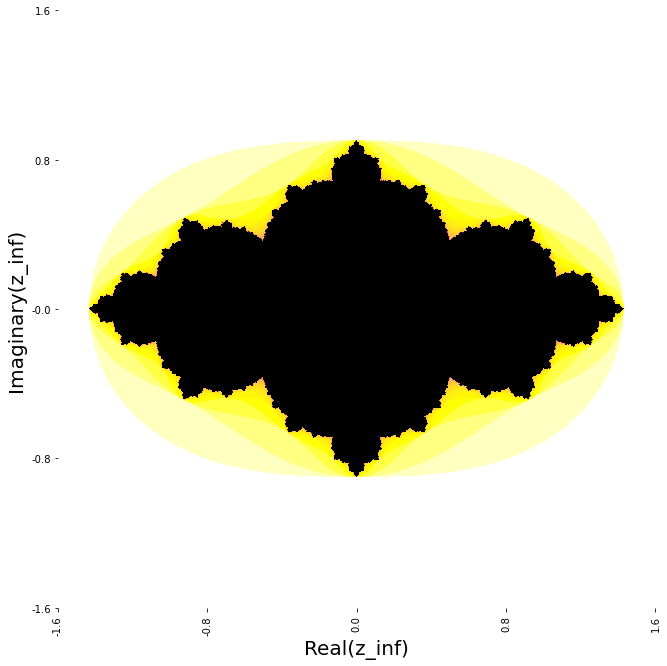

In [5]:
r = 1.6180339887
fig, image = juliaSetRainbow(c = complex(1 - r, 0), size = 1.6, pixels = 2000, max_iterations = 50)
fig

### Different images (just to show)

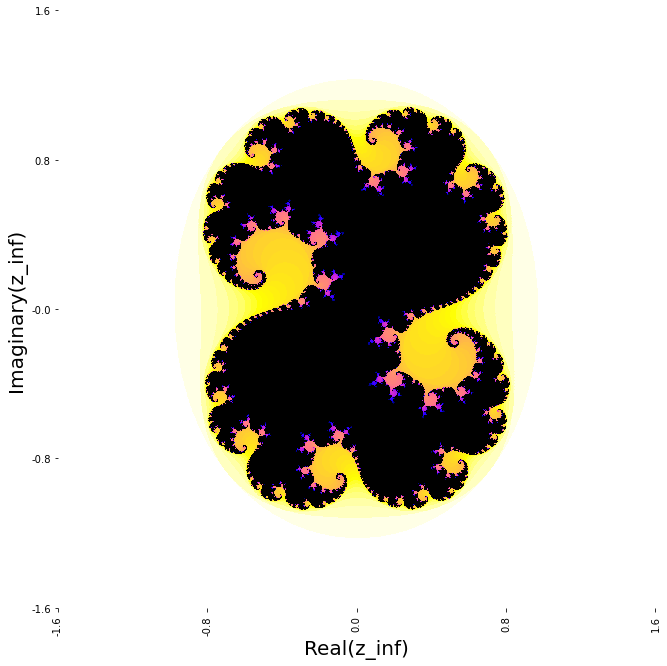

In [6]:
fig, image = juliaSetRainbow(c = complex(0.28, 0.0113), size = 1.6, pixels = 2000, max_iterations = 100)
fig

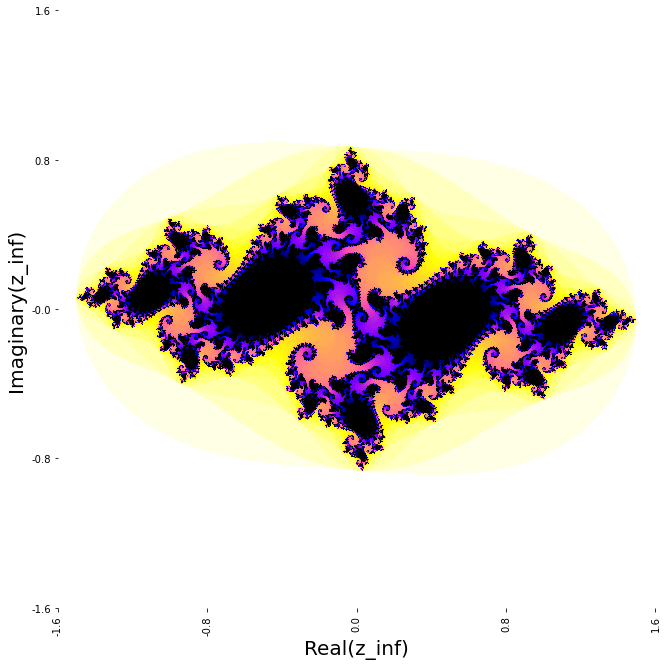

In [7]:
fig, image = juliaSetRainbow(c = complex(-0.74543, 0.11301), size = 1.6, pixels = 2000, max_iterations = 100)
fig

### Subtask 4: Plot figures for c=exp(ia), a = range(0,2pi) & write down axes like in subtask 3, create animation of these figures slowly changing the a - value. title should include values of a. gif should have longitude 1 minute

### Julia Set adopted for visualization

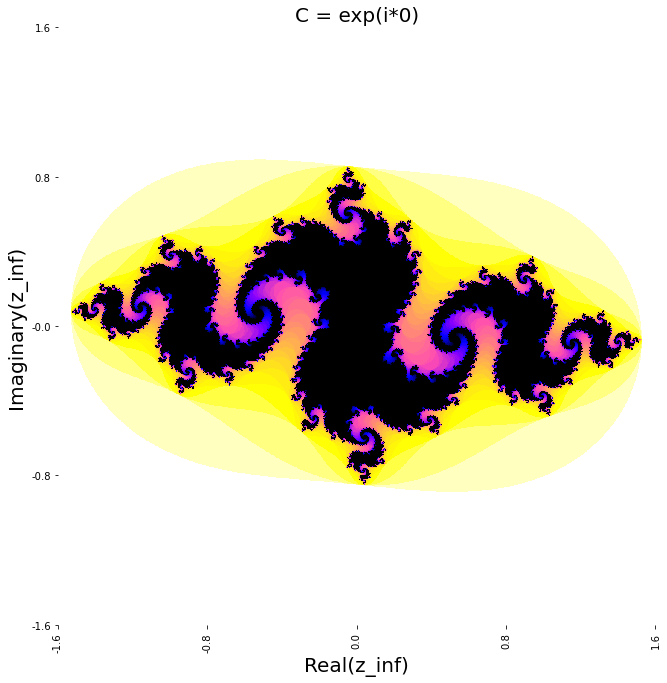

In [8]:
@njit(fastmath=True)
def count(c, size, pixels, max_iterations, infinity_border):
    
    minRe, maxRe, minIm, maxIm = -size, size, -size, size # ranges of Re, Im parts
    pointsRe, pointsIm = pixels, pixels # image size
    max_iterations = max_iterations # the max number of iterations of main function z0 = z0 ** 2 + c
    
    #infinity_border = infinity_border # consider all higher values as infinity
    
    infinity_border = (1 + np.sqrt(1 + 4 * abs(c))) / 2
    image = np.zeros((pointsRe, pointsIm)) # image with black colors
    
    # for each complex value (pixel on Re, Im complex plane)
    for ip, Re in enumerate(np.linspace(minRe, maxRe, pointsRe)): # this axis goes down
        for iq, Im in enumerate(np.linspace(minIm, maxIm, pointsIm)): # this axis goes right
            z0 = complex(Re, Im) # consider current z0
            
            
            
            # do iterations (default color - black = 0)
            # image[ip, iq] = 0 (black)
            for k in range(max_iterations):
                # calculate current z0
                z0 = z0 ** 2 + c
                
                # if z0 highet than infinity_border
                if abs(z0) >= infinity_border:
                    # set colour of pixel:
                    # less k => fast growth, higher k => slow growth
                    # => k = 0 - white, k = max_iterations - black
                    image[ip, iq] =  max_iterations - k
                    break
    
    image[ip, iq] = max_iterations  
    return image

def juliaSetRainbow(c = complex(0.28, 0.0113), size = 1.6, pixels = 100, max_iterations = 100, infinity_border = 300, a_val = 0):
    
    image = count(c, size, pixels, max_iterations, infinity_border)
    image = np.rot90(image)
    
    fig = plt.figure(figsize=(14, 11))
    
    sns.heatmap(image, vmin=0, vmax=max_iterations, center= max_iterations/2, cmap= 'gnuplot2', cbar=False, square=True,
                # cbar_kws= {'orientation': 'vertical'}
               )
    
    plt.title('С = exp(i*' + str(np.round(a_val,3)) + ')', fontsize=20)
    plt.ylabel('Imaginary(z_inf)', fontsize=20)
    plt.xlabel('Real(z_inf)', fontsize=20)
    plt.xticks(np.linspace(0, pixels-1, 5), np.round(np.linspace(-size, size, 5),2))
    plt.yticks(np.linspace(0, pixels-1, 5), -np.round(np.linspace(-size, size, 5),2))
    plt.close(fig)

    return fig, image
    
fig, image = juliaSetRainbow(c = complex(-0.8, 0.15), size = 1.6, pixels = 2000, max_iterations = 50, infinity_border = 0, a_val = 0)
fig

### Saving images

In [9]:
### 1st 180 images

In [10]:
import gc # gc doesn't work? The images are stored in the memory buffer of Python, so it is necessary to generate images using small portions.
import matplotlib.pyplot as plt
nframes = 720
a = np.linspace(0, 2*pi-pi/nframes, nframes)
for i in range(0,180,1):
    fig, image = juliaSetRainbow(c = complex(cos(a[i]), sin(a[i])), size = 1.6, pixels = 1000, max_iterations = 50, infinity_border = 2, a_val = a[i])
    fig.savefig('JuliaImgs/JuliaSet_' + str(i))
    plt.close('all')
    fig = None
    gc.collect()

In [11]:
### 2nd 180 images

In [12]:
import gc
import matplotlib.pyplot as plt
nframes = 720
a = np.linspace(0, 2*pi-pi/nframes, nframes)
for i in range(180,360,1):
    fig, image = juliaSetRainbow(c = complex(cos(a[i]), sin(a[i])), size = 1.6, pixels = 1000, max_iterations = 50, infinity_border = 2, a_val = a[i])
    fig.savefig('JuliaImgs/JuliaSet_' + str(i))
    plt.close('all')
    fig = None
    gc.collect()

In [13]:
### 3rd 180 images

In [14]:
import gc
import matplotlib.pyplot as plt
nframes = 720
a = np.linspace(0, 2*pi-pi/nframes, nframes)
for i in range(360,540,1):
    fig, image = juliaSetRainbow(c = complex(cos(a[i]), sin(a[i])), size = 1.6, pixels = 1000, max_iterations = 50, infinity_border = 2, a_val = a[i])
    fig.savefig('JuliaImgs/JuliaSet_' + str(i))
    plt.close('all')
    fig = None
    gc.collect()

In [15]:
### 4th 180 images

In [16]:
import gc
import matplotlib.pyplot as plt
nframes = 720
a = np.linspace(0, 2*pi-pi/nframes, nframes)
for i in range(540,720,1):
    fig, image = juliaSetRainbow(c = complex(cos(a[i]), sin(a[i])), size = 1.6, pixels = 1000, max_iterations = 50, infinity_border = 2, a_val = a[i])
    fig.savefig('JuliaImgs/JuliaSet_' + str(i))
    plt.close('all')
    fig = None
    gc.collect()

### GIF  Creating 

In [1]:
import glob
from PIL import Image

path = 'JuliaImgs'
images = []
all_files = []
all_files += glob.glob(path+"/*_[0-9].png")
all_files += glob.glob(path+"/*_[0-9][0-9].png")
all_files += glob.glob(path+"/*_[0-9][0-9][0-9].png")
all_files += glob.glob(path+"/*_[0-9][0-9][0-9][0-9].png")

# filepaths
fp_in = all_files
fp_out = "JuliaSet_animation.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in all_files]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=20, loop=0)

In [18]:
path = 'JuliaImgs'
images = []
all_files = []

a = glob.glob(path+"/*_[0-9].png")
a.sort()
all_files += a

b = glob.glob(path+"/*_[0-9][0-9].png")
b.sort()
all_files += b
all_files

c = glob.glob(path+"/*_[0-9][0-9][0-9].png")
c.sort()
all_files += c
all_files

d = glob.glob(path+"/*_[0-9][0-9][0-9][0-9].png")
d.sort()
all_files += d
all_files

['JuliaImgs/JuliaSet_0.png',
 'JuliaImgs/JuliaSet_1.png',
 'JuliaImgs/JuliaSet_2.png',
 'JuliaImgs/JuliaSet_3.png',
 'JuliaImgs/JuliaSet_4.png',
 'JuliaImgs/JuliaSet_5.png',
 'JuliaImgs/JuliaSet_6.png',
 'JuliaImgs/JuliaSet_7.png',
 'JuliaImgs/JuliaSet_8.png',
 'JuliaImgs/JuliaSet_9.png',
 'JuliaImgs/JuliaSet_10.png',
 'JuliaImgs/JuliaSet_11.png',
 'JuliaImgs/JuliaSet_12.png',
 'JuliaImgs/JuliaSet_13.png',
 'JuliaImgs/JuliaSet_14.png',
 'JuliaImgs/JuliaSet_15.png',
 'JuliaImgs/JuliaSet_16.png',
 'JuliaImgs/JuliaSet_17.png',
 'JuliaImgs/JuliaSet_18.png',
 'JuliaImgs/JuliaSet_19.png',
 'JuliaImgs/JuliaSet_20.png',
 'JuliaImgs/JuliaSet_21.png',
 'JuliaImgs/JuliaSet_22.png',
 'JuliaImgs/JuliaSet_23.png',
 'JuliaImgs/JuliaSet_24.png',
 'JuliaImgs/JuliaSet_25.png',
 'JuliaImgs/JuliaSet_26.png',
 'JuliaImgs/JuliaSet_27.png',
 'JuliaImgs/JuliaSet_28.png',
 'JuliaImgs/JuliaSet_29.png',
 'JuliaImgs/JuliaSet_30.png',
 'JuliaImgs/JuliaSet_31.png',
 'JuliaImgs/JuliaSet_32.png',
 'JuliaImgs/JuliaSet